<a href="https://colab.research.google.com/github/fmhirwa/alu-Y3T2_sentiment_analysis/blob/main/Sentiment_Analysis_G2_S22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis
Peer Group 2
FLorent Hirwa
Raisa Irakoze
Alhassan Alimamy Dumbuya

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
import kagglehub
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


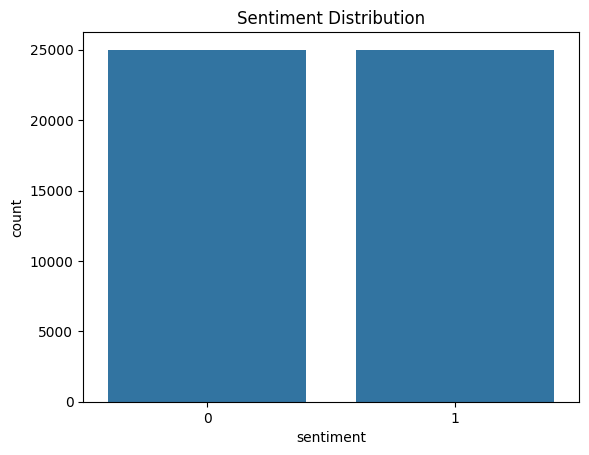

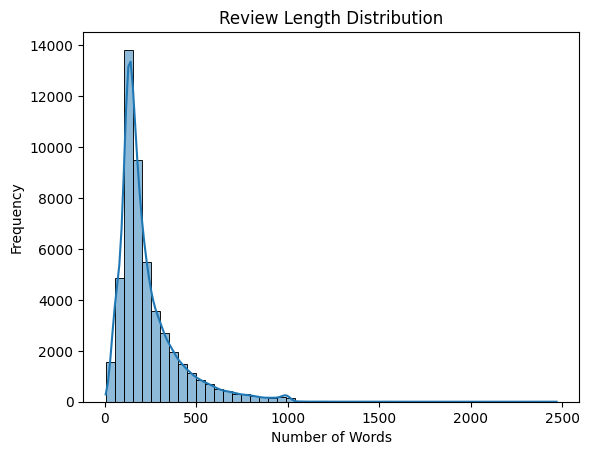

In [8]:
# Download latest dataset version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

# Load IMDB dataset
df = pd.read_csv(path + "/IMDB Dataset.csv")
df = df[['review', 'sentiment']]
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# EDA: Class distribution
sns.countplot(x=df['sentiment'])
plt.title("Sentiment Distribution")
plt.show()

# Review length distribution
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [9]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
df['clean_text'] = df['review'].apply(preprocess_text)

In [10]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sentiment'], test_size=0.2, random_state=42)

# TF-IDF Vectorization for Logistic Regression
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression Model
log_model = LogisticRegression()
log_model.fit(X_train_tfidf, y_train)
y_pred_lr = log_model.predict(X_test_tfidf)

# Evaluate Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.887
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [11]:
# Tokenization for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200)

# LSTM Model
model = Sequential([
    Embedding(5000, 128, input_length=200),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_data=(X_test_seq, y_test))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 207s 325ms/step - accuracy: 0.7844 - loss: 0.4436 - val_accuracy: 0.8805 - val_loss: 0.2843
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 209s 334ms/step - accuracy: 0.9042 - loss: 0.2503 - val_accuracy: 0.8829 - val_loss: 0.2816
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 336ms/step - accuracy: 0.9228 - loss: 0.2050 - val_accuracy: 0.8788 - val_loss: 0.2875
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 332ms/step - accuracy: 0.9380 - loss: 0.1707 - val_accuracy: 0.8808 - val_loss: 0.3192
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 334ms/step - accuracy: 0.9525 - loss: 0.1337 - val_accuracy: 0.8809 - val_loss: 0.3326


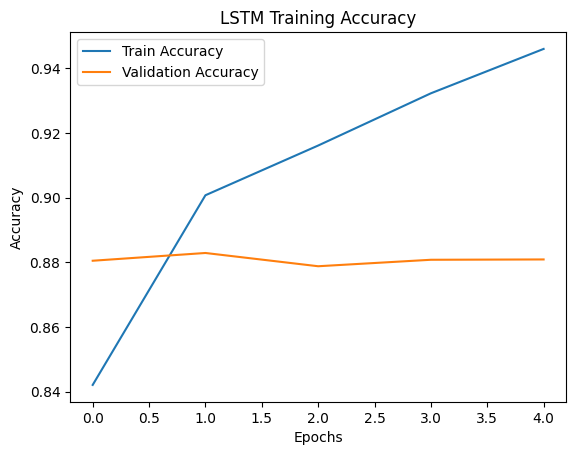

In [13]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:

# Evaluate LSTM
y_pred_lstm = (model.predict(X_test_seq) > 0.5).astype("int32")
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))



313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step
LSTM Accuracy: 0.8809
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



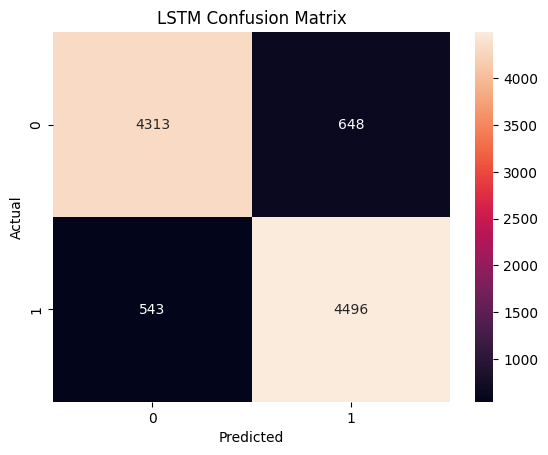

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


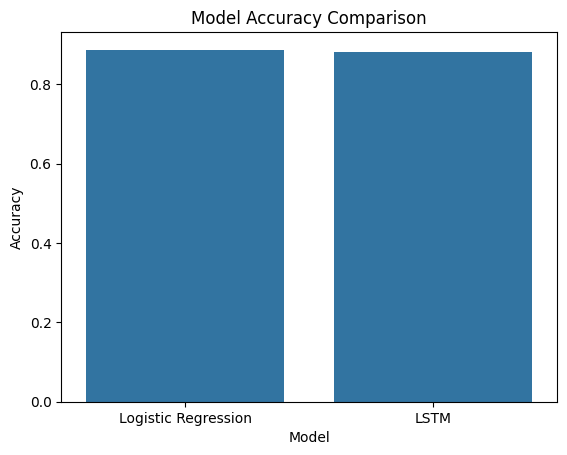

                 Model  Accuracy
0  Logistic Regression    0.8870
1                 LSTM    0.8809


In [17]:
# Comparison
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'LSTM'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_lstm)]
})

# Bar plot for model comparison
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

print(results)